# CNES – Forecasting de profissionais por 1.000 hab. (Apenas Regressão Linear)
Notebook organizado para trabalhar **apenas com Regressão Linear** usando um **corte temporal (80/20)** e **features declaradas em um único lugar**.

Defina abaixo o `DATA_PATH` para o CSV com as métricas (ex.: `estabelecimentos_sp_metricas_acima_100k.csv`).

## 1) Setup

In [21]:
# !pip install pandas numpy scikit-learn matplotlib seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


## 2) Caminho dos dados

In [22]:
# Ajuste aqui para o seu arquivo
DATA_PATH = "/Users/caio.maximiano/pessoal/cnes-project-analysis/local_storage/estabelecimentos_sp_metricas.csv"  # altere se necessário


## 3) Carregar e preparar dados

In [31]:
# Carregar CSV
df = pd.read_csv(DATA_PATH).query("POPULACAO_MENSAL >= 50000 and NO_MUNICIPIO not in ['SAO PAULO','JERIQUARA'] and PROFISSIONAIS_POR_1000 <= 10 ") # filtrar outliers

# Garantir coluna de data
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
elif {'YYYY','MM'}.issubset(df.columns):
    df['date'] = pd.to_datetime(df['YYYY'].astype(str) + '-' + df['MM'].astype(str) + '-01')
else:
    raise ValueError('Não encontrei coluna de data. Forneça col "date" ou (YYYY, MM).')

# Ordenar temporalmente
df = df.sort_values('date').reset_index(drop=True)

print('Shape:', df.shape)
df.head(3)


Shape: (140034, 16)


,CO_MUNICIPIO_SEM_DIGITO,YYYY,MM,NO_MUNICIPIO,DS_ATIVIDADE_PROFISSIONAL,TOTAL_PROFISSIONAIS,CO_UF,NO_UF,NO_REGIAO,NO_MUNICIPIO_IBGE,POPULACAO_MENSAL,POPULACAO,GROWTH_ABS,GROWTH_PCT,PROFISSIONAIS_POR_1000,date
0,351870,2022,1,GUARUJA,MEDICO GINECOLOGISTA E OBSTETRA,63,35.0,São Paulo,São Paulo,GUARUJA,314651.0,314651.0,-864.0,-0.002738,0.200222,2022-01-01
1,353060,2022,1,MOGI DAS CRUZES,MEDICO MASTOLOGISTA,8,35.0,São Paulo,São Paulo,MOGI DAS CRUZES,459727.0,459727.0,353.0,0.000768,0.017402,2022-01-01
2,355250,2022,1,SUZANO,MEDICO NEFROLOGISTA,8,35.0,São Paulo,São Paulo,SUZANO,308436.0,308436.0,431.0,0.001399,0.025937,2022-01-01


## 4) Declarar **features** e **alvo** (uma única vez)

In [24]:
# Índice temporal (para regressão linear)
df["time_index"] = df.groupby(["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL"]).cumcount() + 1

# Lags e rolling
df["lag1"] = df.groupby(["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL"])["PROFISSIONAIS_POR_1000"].shift(1)
df["rolling3"] = df.groupby(["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL"])["PROFISSIONAIS_POR_1000"].transform(lambda x: x.rolling(3).mean())

# Target e features
TARGET_COL = 'PROFISSIONAIS_POR_1000'   # alvo contínuo
CAT_COLS   = ['NO_MUNICIPIO', 'DS_ATIVIDADE_PROFISSIONAL']
NUM_COLS   = ['POPULACAO_MENSAL', 'GROWTH_PCT', 'lag1', 'rolling3', 'time_index']

FEATURES = CAT_COLS + NUM_COLS

# Sanidade: remover linhas sem as features ou sem alvo
df_model = df.dropna(subset=FEATURES + [TARGET_COL]).copy()

print('Linhas após dropna(features+target):', df_model.shape[0])
df_model[FEATURES + [TARGET_COL]].head(3)


Linhas após dropna(features+target): 131220


,NO_MUNICIPIO,DS_ATIVIDADE_PROFISSIONAL,POPULACAO_MENSAL,GROWTH_PCT,lag1,rolling3,time_index,PROFISSIONAIS_POR_1000
7829,ITATIBA,MEDICO CIRURGIAO GERAL,125082.0,0.000440,0.287938,0.285275,3,0.287811
7830,TUPA,MEDICO ANGIOLOGISTA,65538.0,-0.000076,0.015257,0.015257,3,0.015258
7831,OURINHOS,MEDICO CARDIOLOGISTA INTERVENCIONISTA,111866.0,-0.001909,0.071378,0.071373,3,0.071514


## 5) Split temporal (80% treino / 20% teste) – Global

In [25]:
# Data de corte (80% das datas distintas)
unique_dates = sorted(df_model['date'].unique())
cut_idx = int(len(unique_dates) * 0.8)
cut_date = unique_dates[cut_idx]

X = df_model[FEATURES].copy()
y = df_model[TARGET_COL].copy()

X_train = X[df_model['date'] <  cut_date]
y_train = y[df_model['date'] <  cut_date]
X_test  = X[df_model['date'] >= cut_date]
y_test  = y[df_model['date'] >= cut_date]

print('Datas treino até:', pd.to_datetime(cut_date).date())
print('Train:', X_train.shape, ' Test:', X_test.shape)


Datas treino até: 2024-10-01
Train: (102729, 7)  Test: (28491, 7)


## 6) Pipeline (One-Hot nas categóricas) + Regressão Linear

In [26]:
pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), CAT_COLS),
    ('num', 'passthrough', NUM_COLS)
])

pipe = Pipeline([
    ('pre', pre),
    ('lr', LinearRegression())
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print('=== Avaliação (GLOBAL) – Linear Regression ===')
print(f'MAE : {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R²  : {r2:.4f}')


=== Avaliação (GLOBAL) – Linear Regression ===
MAE : 0.0099
RMSE: 0.0342
R²  : 0.9911


In [27]:
pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), CAT_COLS),
    ('num', 'passthrough', NUM_COLS)
])

pipe = Pipeline([
    ('pre', pre),
    ('lr', LinearRegression())
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print('=== Avaliação (GLOBAL) – Linear Regression ===')
print(f'MAE : {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R²  : {r2:.4f}')


=== Avaliação (GLOBAL) – Linear Regression ===
MAE : 0.0099
RMSE: 0.0342
R²  : 0.9911


## 8) Função para avaliar por cidade/especialidade (opcional)

In [28]:
def evaluate_linear_by_subset(df_subset: pd.DataFrame):
    """Avaliacao temporal 80/20 para um subconjunto (ex.: cidade+especialidade)."""
    df_subset = df_subset.dropna(subset=FEATURES + [TARGET_COL]).sort_values('date').copy()
    if df_subset['date'].nunique() < 12:
        return None

    unique_dates = sorted(df_subset['date'].unique())
    cut_idx = int(len(unique_dates) * 0.8)
    cut_date = unique_dates[cut_idx]

    Xs = df_subset[FEATURES]
    ys = df_subset[TARGET_COL]

    X_tr = Xs[df_subset['date'] <  cut_date]
    y_tr = ys[df_subset['date'] <  cut_date]
    X_te = Xs[df_subset['date'] >= cut_date]
    y_te = ys[df_subset['date'] >= cut_date]

    pre = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), CAT_COLS),
        ('num', 'passthrough', NUM_COLS)
    ])
    pipe_local = Pipeline([('pre', pre), ('lr', LinearRegression())])
    pipe_local.fit(X_tr, y_tr)
    y_hat = pipe_local.predict(X_te)

    return {
        'mae': mean_absolute_error(y_te, y_hat),
        'rmse': root_mean_squared_error(y_te, y_hat),
        'r2': r2_score(y_te, y_hat),
        'dates_test': df_subset.loc[X_te.index, 'date'],
        'y_test': y_te,
        'y_pred': y_hat,
        'model': pipe_local
    }


## 9) Exemplo de avaliação por cidade/especialidade

SOROCABA / MEDICO CLINICO -> MAE=0.0634 | RMSE=0.0772 | R²=0.5139


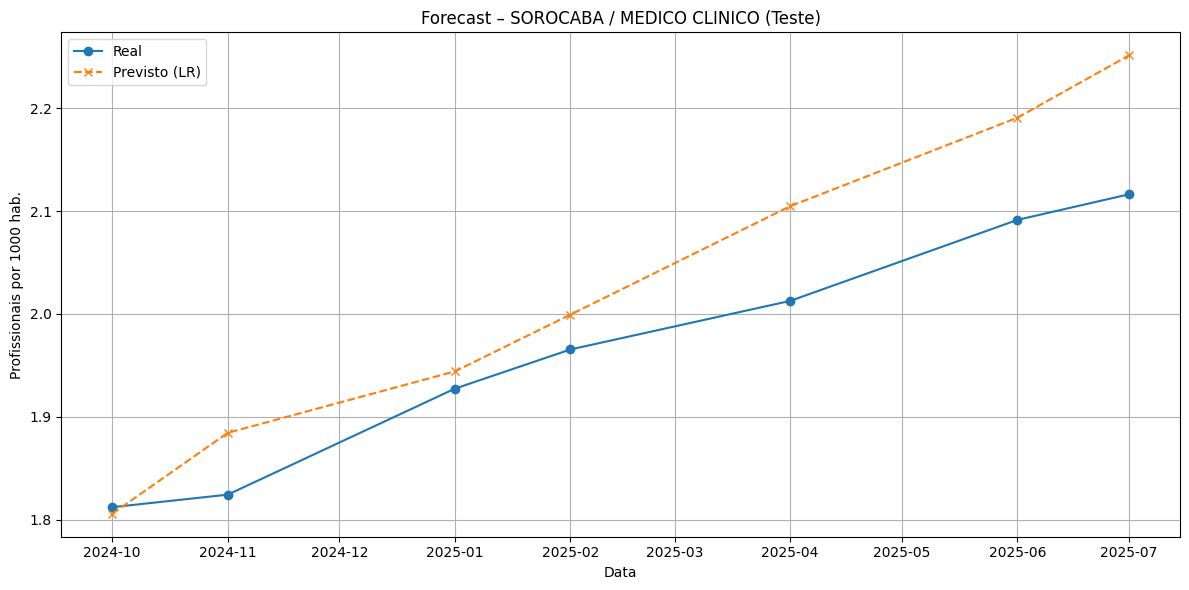

In [29]:
city = 'SOROCABA'
specialty = 'MEDICO CLINICO'

df_sub = df_model.query('NO_MUNICIPIO == @city and DS_ATIVIDADE_PROFISSIONAL == @specialty').copy()
res = evaluate_linear_by_subset(df_sub)

if res:
    print(f"{city} / {specialty} -> MAE={res['mae']:.4f} | RMSE={res['rmse']:.4f} | R²={res['r2']:.4f}")
    plt.figure(figsize=(12,6))
    plt.plot(res['dates_test'], res['y_test'], marker='o', label='Real')
    plt.plot(res['dates_test'], res['y_pred'], marker='x', linestyle='--', label='Previsto (LR)')
    plt.title(f'Forecast – {city} / {specialty} (Teste)')
    plt.xlabel('Data'); plt.ylabel('Profissionais por 1000 hab.')
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()
else:
    print('Subconjunto com menos de 12 meses distintos; pulei.')


## 10) Função para projetar próximos N meses (subset local)

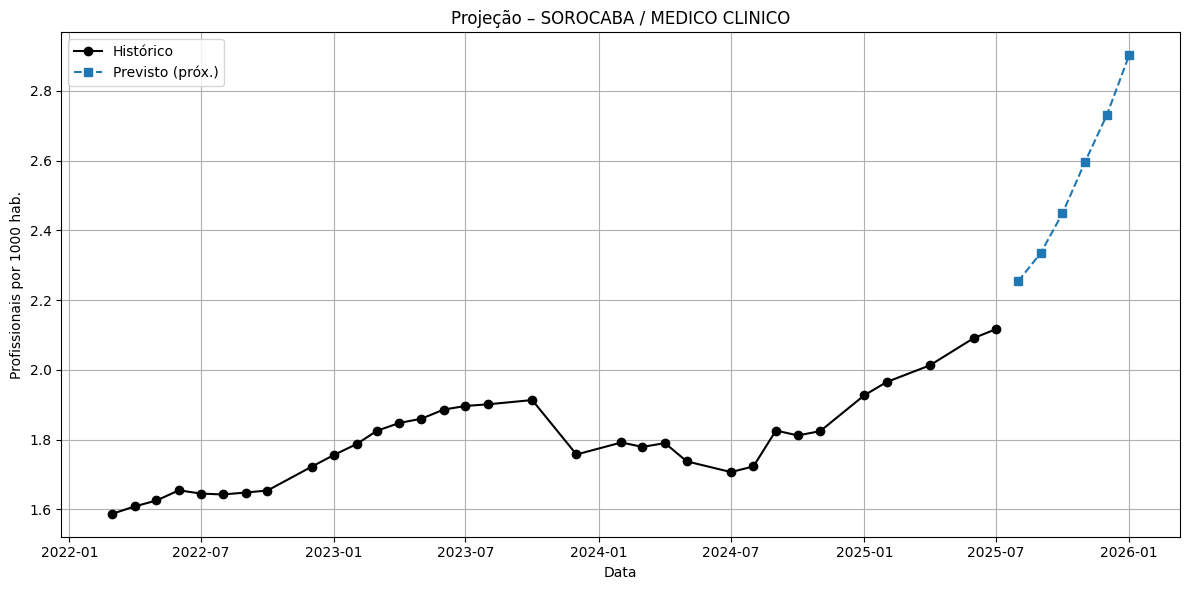

In [32]:
def forecast_n_months(df_subset, model, n_months=3):
    df_subset = df_subset.sort_values('date').copy()
    last = df_subset.iloc[-1].copy()

    history = df_subset[TARGET_COL].dropna().tolist()
    growth = float(df_subset['GROWTH_PCT'].tail(3).mean()) if not df_subset['GROWTH_PCT'].tail(3).isna().all() else 0.0

    next_date = last['date'] + pd.offsets.MonthBegin(1)
    next_ti = int(last.get('time_index', len(df_subset))) + 1

    rows = []
    for _ in range(n_months):
        pop_next = int(last['POPULACAO_MENSAL'] * (1 + growth))
        lag1 = history[-1]
        rolling3 = np.mean(history[-3:]) if len(history) >= 3 else np.mean(history)

        feat = {
            'POPULACAO_MENSAL': pop_next,
            'GROWTH_PCT': growth,
            'lag1': float(lag1),
            'rolling3': float(rolling3),
            'time_index': next_ti,
            'NO_MUNICIPIO': last['NO_MUNICIPIO'],
            'DS_ATIVIDADE_PROFISSIONAL': last['DS_ATIVIDADE_PROFISSIONAL'],
        }
        X_next = pd.DataFrame([feat], columns=FEATURES)
        y_next = float(model.predict(X_next)[0])

        rows.append({'date': next_date, TARGET_COL: y_next})
        history.append(y_next)
        last['POPULACAO_MENSAL'] = pop_next
        next_date += pd.offsets.MonthBegin(1)
        next_ti += 1

    return pd.DataFrame(rows)

# Exemplo de uso (se res existir)
if 'res' in locals() and res and res['model'] is not None:
    fut = forecast_n_months(df_sub, res['model'], n_months=6)
    plt.figure(figsize=(12,6))
    plt.plot(df_sub['date'], df_sub[TARGET_COL], 'ko-', label='Histórico')
    plt.plot(fut['date'], fut[TARGET_COL], 's--', label='Previsto (próx.)')
    plt.xlabel('Data'); plt.ylabel('Profissionais por 1000 hab.')
    plt.title(f'Projeção – {city} / {specialty}')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [33]:
import joblib
joblib.dump(pipe, '/Users/caio.maximiano/pessoal/cnes-project-analysis/exploration/entregas/pipeline.joblib')

['/Users/caio.maximiano/pessoal/cnes-project-analysis/exploration/entregas/pipeline.joblib']